In [54]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
%matplotlib inline

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units

import cartopy.crs as ccrs
import cartopy

import sys
p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
from orographicPrecipitation.precip_model_functions import qsat
from scipy.ndimage import gaussian_filter

import warnings

# Functions

In [2]:
ERA5M_PATH  = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
ERA5M_PATH2 = "/global/project/projectdirs/m3310/wboos/era5monthly/"

boxNH = [[-100, -70, 12 , 20],
         [-80 , -60, 8  , 16],
         [70  , 90 , 2  , 18],
         [100 , 120, 8  , 20],
         [118 , 140, 4  , 20],
         [100 , 110, 0  , 12],
        ]

boxSH = [[20  , 50 , -20, 0 ],
         [-60 , -30, -20, 0 ],
        ]

boxNH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxNH]
boxSH1 = [[b[0]%360,b[1]%360,b[2],b[3]] for b in boxSH]

namesNH = ["Central America",
           "Venezuela",
           "South India / Sri Lanka",
           "Vietnam / South China Sea",
           "Philippines",
           "Malaysia"
          ]
namesSH = ["Tanzania",
           "NorthEast Brazil"
          ]

In [67]:
#Data extraction from ERA5
era5yrs = list(range(1979,2019))

def era5_file(year,varid):
    """return file path to an ERA5 variable for the year 'year'
    varid gives the id of the variable in era5
        - year : str, "YYYY"
        - varid : str, eg. "128_130_t" for temperature
    """
    try :
        fpath = glob.glob(os.path.join(ERA5M_PATH,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    except IndexError :
        path = "/global/cscratch1/sd/qnicolas/era5monthly/"
        fpath = glob.glob(os.path.join(path,"*/e5.*.%s.*.%s*.nc"%(varid,year)))[0]
    return fpath


def climatology_era5(varid):
    paths = [era5_file(year,varid) for year in era5yrs]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",FutureWarning)
        ds = xr.open_mfdataset(paths).groupby("time.month").mean("time").compute()
        varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
        return ds[varname]

def climatology_era5_1998(varid):
    paths = [era5_file(year,varid) for year in list(range(1998,2014))]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",FutureWarning)
        ds = xr.open_mfdataset(paths).groupby("time.month").mean("time").compute()
        varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
        return ds[varname]
    
def climatology_era5_level(month,varid,level):
    paths = [era5_file(year,varid) for year in era5yrs]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",FutureWarning)
        ds = xr.open_mfdataset(paths).sel(level=level).groupby("time.month").mean("time").compute()
        varname = list(ds.data_vars)[0] #get name of the main variable, eg 'T' for temperature
        return ds[varname]


def region_mean2D(variable,mask,box):
    """Given a 2D variable (lat, lon), compute a spatial mean within a specified region
    defined by a mask, inside a given box
        - variable = 3D xarray.dataarray. Dimensions must be named "latitude" and "longitude"
        - mask = 2D xarray.dataarray of 0s and 1s. Must have same grid and dimension names as 'variable'
        - box = list of four items, [lon1, lon2, lat1, lat2]
    """
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean

def region_mean2D_trmm(variable,mask,box):
    mask_box = mask.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    variable_box = variable.fillna(0).sel(longitude=slice(box[0],box[1]),latitude=slice(box[2],box[3]))
    maskedvar = variable_box*mask_box
    region_mean = maskedvar.fillna(0).sum(["latitude","longitude"])/ mask_box.sum(["latitude","longitude"])
    return region_mean


    return vartot/len(era5yrs)



# Masks, data

In [5]:
def slide_coord(mask):
    """Switch the longitude coord from (-180,180) to (0,360) 
    and change coordinate names from 'LAT1','LON1' to 'latitude' and 'longitude'"""
    mask0=mask.copy()
    mask0.coords['longitude'] = mask0.coords['LON1']%360
    mask1 = mask0.swap_dims({'LON1': 'longitude'}).rename({'LAT1': 'latitude'})

    #Sort the longitude values
    sort_inds = {"longitude": np.argsort(mask1["longitude"].values)}
    mask1 = mask1.isel(**sort_inds)
    return mask1

masks = xr.open_dataset("/global/cscratch1/sd/qnicolas/masks/winter_rainfall_masks.nc")
##/!\ temporary change for access on Spin
##masks = xr.open_dataset("winter_rainfall_masks.nc")
trmm_nh_winter_mask = masks.TRMM_NH_WINTER_MASK.fillna(0.)
trmm_sh_winter_mask = masks.TRMM_SH_WINTER_MASK.fillna(0.)


## To be modified
REFERENCE_GRID = xr.open_dataset(ERA5M_PATH+"e5.moda.an.pl/e5.moda.an.pl.128_060_pv.ll025sc.1979010100_1979120100.nc").PV.sel(latitude=slice(50., -50.)).isel(time=0) #to get the era5 grid

trmm_nh_winter_mask1 = (slide_coord(trmm_nh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_sh_winter_mask1 = (slide_coord(trmm_sh_winter_mask).interp_like(REFERENCE_GRID) > 0)*1.
trmm_nh_winter_mask2 = slide_coord(trmm_nh_winter_mask)
trmm_sh_winter_mask2 = slide_coord(trmm_sh_winter_mask)                     

In [6]:
CMIP6_FOLDER="/global/cfs/projectdirs/m3522/cmip6/"

landmask = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
landmask50=landmask.interp_like(REFERENCE_GRID)


In [7]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

ddxorog = xr.apply_ufunc(gaussian_filter,ddxorog,kwargs={"sigma":2.})
ddyorog = xr.apply_ufunc(gaussian_filter,ddyorog,kwargs={"sigma":2.})

In [8]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_seasmean = pr_trmm_all.groupby("time.month").mean("time")

# Vertical motions

In [68]:
t=time.time()
u_seasmean_9813 = climatology_era5_1998('128_131_u')
print(time.time()-t)

274.838463306427


In [ ]:
t=time.time()
v_seasmean_9813 = climatology_era5_1998('128_132_v')
print(time.time()-t)

In [ ]:
t=time.time()
w_seasmean_9813 = climatology_era5_1998('128_135_w')
print(time.time()-t)
w_seasmean_9813.to_netcdf("e5.moda.an.pl.128_135_w.ll025sc.1998010100_2013120100.seasonalmean.nc")

In [71]:
u_seasmean_9813.to_netcdf("e5.moda.an.pl.128_131_u.ll025sc.1998010100_2013120100.seasonalmean.nc")
v_seasmean_9813.to_netcdf("e5.moda.an.pl.128_132_v.ll025sc.1998010100_2013120100.seasonalmean.nc")
#u_seasmean_9813.to_netcdf("e5.moda.an.pl.128_135_w.ll025sc.1998010100_2013120100.seasonalmean.nc")

In [22]:
u_seasmean=xr.open_dataset("e5.moda.an.pl.128_131_u.ll025sc.1979010100_2018120100.seasonalmean.nc").U
v_seasmean=xr.open_dataset("e5.moda.an.pl.128_132_v.ll025sc.1979010100_2018120100.seasonalmean.nc").V
w_seasmean=xr.open_dataset("e5.moda.an.pl.128_135_w.ll025sc.1979010100_2018120100.seasonalmean.nc").W

In [23]:
t_seasmean=xr.open_dataset("e5.moda.an.pl.128_130_t.ll025sc.1979010100_2018120100.seasonalmean.nc").T
rho_seasmean = t_seasmean.level*100/t_seasmean/287.

In [24]:
np.array(rho_seasmean.mean(["month",'latitude','longitude']))

array([0.0013362 , 0.00271494, 0.00418907, 0.00732159, 0.01054684,
       0.01538593, 0.03172299, 0.04836786, 0.08215813, 0.11673583,
       0.16773816, 0.20730201, 0.24535596, 0.28275037, 0.31981091,
       0.35621884, 0.39151583, 0.45769121, 0.51879252, 0.5771351 ,
       0.63416372, 0.69053659, 0.74657485, 0.80267951, 0.85897066,
       0.91500709, 0.9705103 , 0.99825738, 1.02607855, 1.05408076,
       1.08224622, 1.11041292, 1.13838513, 1.16602878, 1.19322578,
       1.2195466 , 1.24468469])

In [13]:
ps_seasmean = climatology_era5('128_134_sp')

In [12]:
t=time.time()
u100_seasmean = climatology_era5("228_246_100u")
v100_seasmean = climatology_era5("228_247_100v")
print(time.time()-t)

38.650646924972534


In [25]:
u_pmean_seasmean = u_seasmean.sel(level=slice(800.,1100.)).where(u_seasmean.level<ps_seasmean/100.).mean('level')
v_pmean_seasmean = v_seasmean.sel(level=slice(800.,1100.)).where(v_seasmean.level<ps_seasmean/100.).mean('level')

In [29]:
rhow_upslope = rho_seasmean*(u_pmean_seasmean*ddxorog+v_pmean_seasmean*ddyorog)

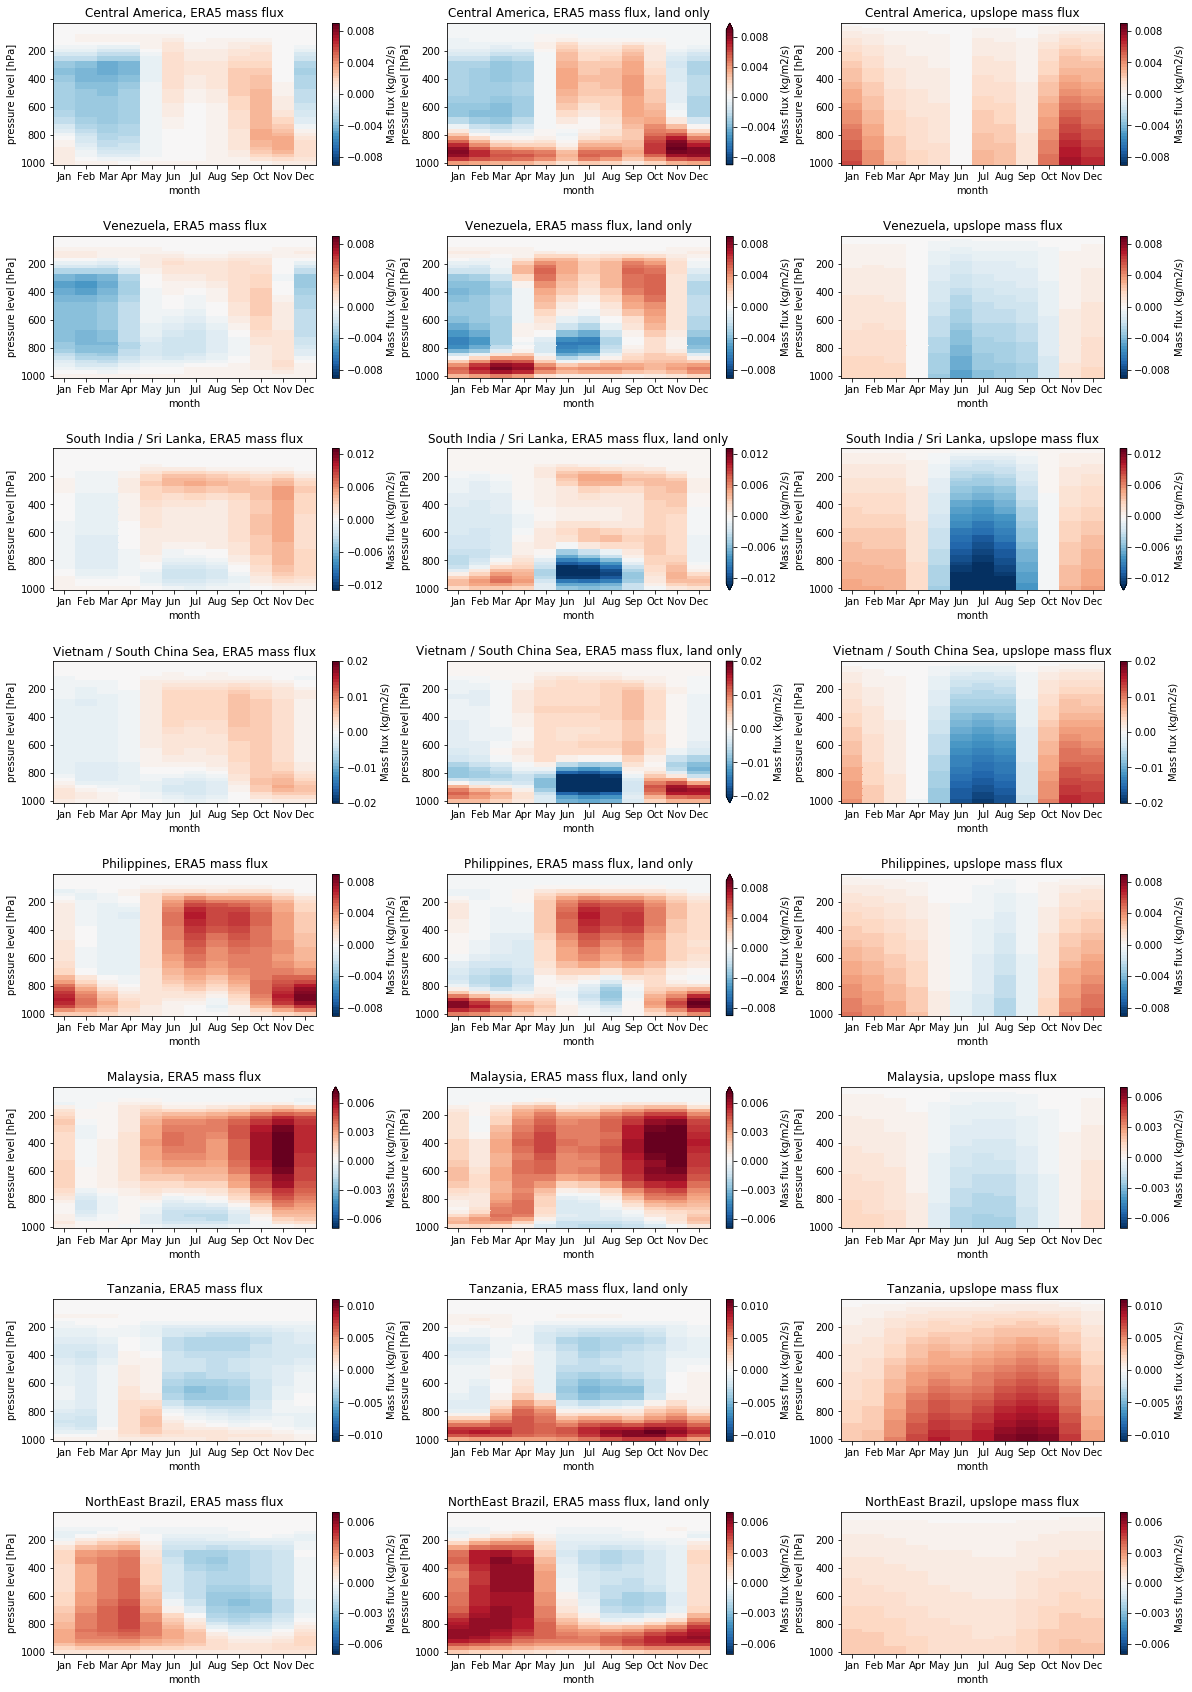

In [62]:
fig, ax = plt.subplots(8,3,figsize=(20,30))
lvls = [(0.009,0.008,0.004),
        (0.009,0.008,0.004),
        (0.013,0.012,0.006),
        (0.02,0.02,0.01),
        (0.009,0.008,0.004),
        (0.007,0.006,0.003),
        (0.011,0.01,0.005),
        (0.007,0.006,0.003),
       ]
mnths=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
    else :
        mask = trmm_sh_winter_mask1
    
    era5mf = region_mean2D(-w_seasmean/9.81,mask,box)
    era5mfl = region_mean2D(-w_seasmean/9.81,mask*landmask50,box)
    upslmf = region_mean2D(rhow_upslope,mask*landmask50,box)
    
    era5mf.plot(ax=ax[i][0], x='month',yincrease=False,cbar_kwargs={"label":"Mass flux (kg/m2/s)","ticks":np.arange(-lvls[i][1],lvls[i][1]+1e-6,lvls[i][2])},cmap=plt.cm.RdBu_r,levels=np.linspace(-lvls[i][0],lvls[i][0]))
    era5mfl.plot(ax=ax[i][1],x='month',yincrease=False,cbar_kwargs={"label":"Mass flux (kg/m2/s)","ticks":np.arange(-lvls[i][1],lvls[i][1]+1e-6,lvls[i][2])},cmap=plt.cm.RdBu_r,levels=np.linspace(-lvls[i][0],lvls[i][0]))
    upslmf.plot(ax=ax[i][2], x='month',yincrease=False,cbar_kwargs={"label":"Mass flux (kg/m2/s)","ticks":np.arange(-lvls[i][1],lvls[i][1]+1e-6,lvls[i][2])},cmap=plt.cm.RdBu_r,levels=np.linspace(-lvls[i][0],lvls[i][0]))

    ax[i][0].set_title((namesNH+namesSH)[i]+ ", ERA5 mass flux")
    ax[i][1].set_title((namesNH+namesSH)[i]+ ", ERA5 mass flux, land only")
    ax[i][2].set_title((namesNH+namesSH)[i]+ ", upslope mass flux")

for a in ax.reshape(-1):
    a.set_xticks(range(1,len(mnths)+1))
    a.set_xticklabels(mnths)

plt.subplots_adjust(hspace=0.5)

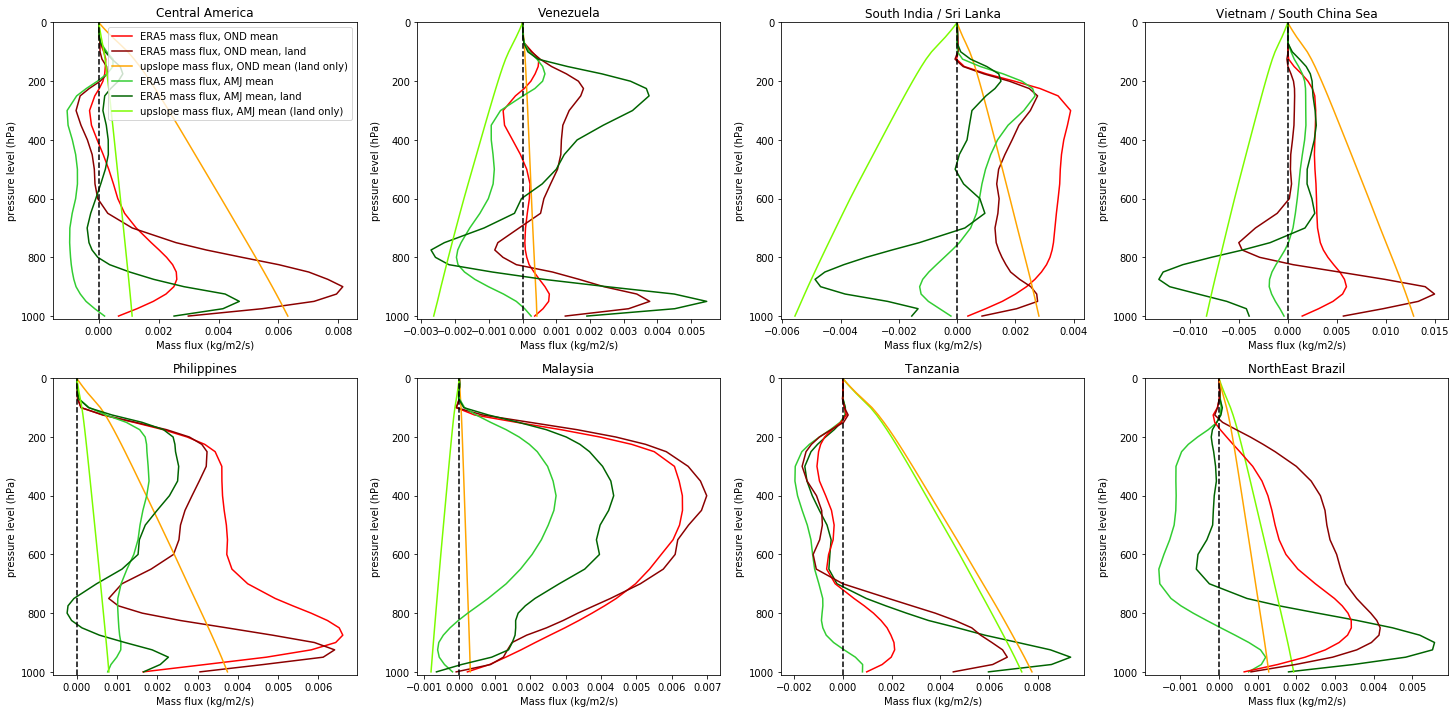

In [72]:
fig, ax = plt.subplots(2,4,figsize=(25,12))
ax = ax.reshape(-1)

for i,box in enumerate(boxNH1+boxSH1):
    if i<6:
        mask = trmm_nh_winter_mask1
        c1 = ["red","darkred","orange"]
        c2 = ["limegreen","darkgreen","lawngreen"]
    else :
        mask = trmm_sh_winter_mask1
        c2 = ["red","darkred","orange"]
        c1 = ["limegreen","darkgreen","lawngreen"]
    
    era5mf = region_mean2D(-w_seasmean/9.81,mask,box)
    era5mfl = region_mean2D(-w_seasmean/9.81,mask*landmask50,box)
    upslmf = region_mean2D(rhow_upslope,mask*landmask50,box)
    
    ax[i].plot(era5mf.sel(month=slice(10,12)).mean("month"),era5mf.level ,label="ERA5 mass flux, OND mean",color = c1[0])
    ax[i].plot(era5mfl.sel(month=slice(10,12)).mean("month"),era5mfl.level ,label="ERA5 mass flux, OND mean, land",color = c1[1])
    ax[i].plot(upslmf.sel(month=slice(10,12)).mean("month"),upslmf.level ,label="upslope mass flux, OND mean (land only)",color = c1[2])
    ax[i].plot(era5mf.sel(month=slice(4,6)).mean("month"),era5mf.level ,label="ERA5 mass flux, AMJ mean",color = c2[0])
    ax[i].plot(era5mfl.sel(month=slice(4,6)).mean("month"),era5mfl.level ,label="ERA5 mass flux, AMJ mean, land",color = c2[1])
    ax[i].plot(upslmf.sel(month=slice(4,6)).mean("month"),upslmf.level ,label="upslope mass flux, AMJ mean (land only)",color = c2[2])
    ax[i].axvline(0,linestyle='--',color="k")
    ax[i].set_xlabel("Mass flux (kg/m2/s)")
    ax[i].set_ylabel("pressure level (hPa)")
    ax[i].set_ylim(1010, 0)
    #ax[i].legend(loc='upper left')
    ax[i].set_title((namesNH+namesSH)[i])
    

ax[0].legend()




# 2d maps of precip vs Roe model

In [20]:
t=time.time()
mean_2t_nov = climat_mean("11","128_167_2t"); mean_2t_may = climat_mean("05","128_167_2t")
mean_sp_nov = climat_mean("11","128_134_sp"); mean_sp_may = climat_mean("05","128_134_sp")
print(time.time()-t)

38.36206364631653


In [67]:
pr_roe_nov = np.maximum(-86400*qsat(mean_2t_nov,mean_sp_nov/100.)*mean_wupslope_nov/9.81,0.)
pr_roe_may = np.maximum(-86400*qsat(mean_2t_may,mean_sp_may/100.)*mean_wupslope_may/9.81,0.)


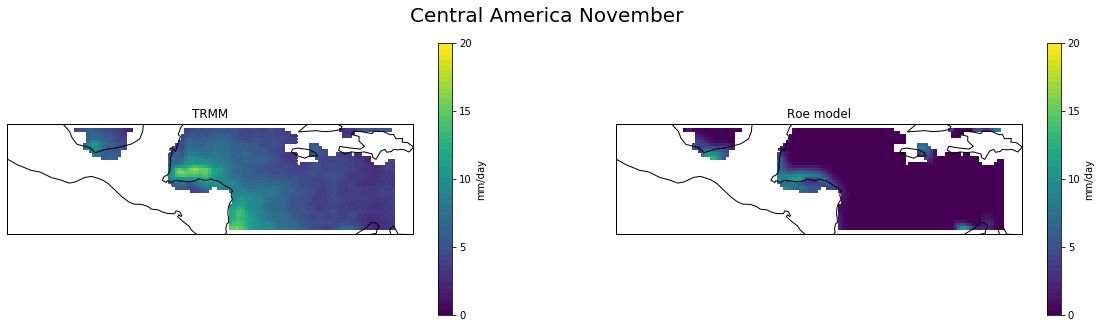

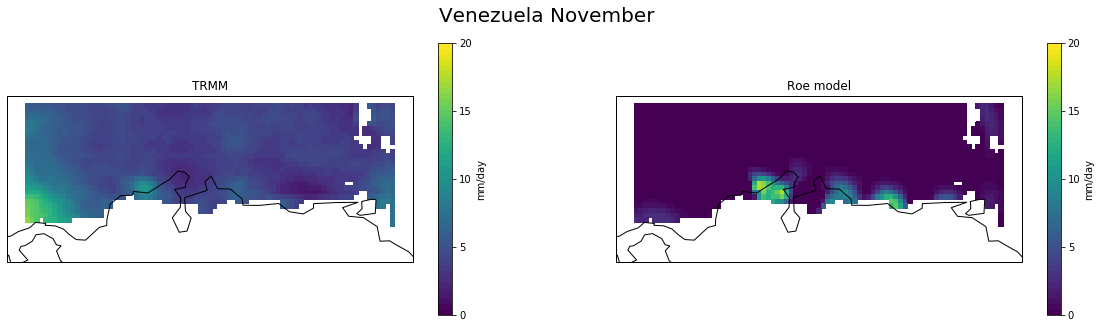

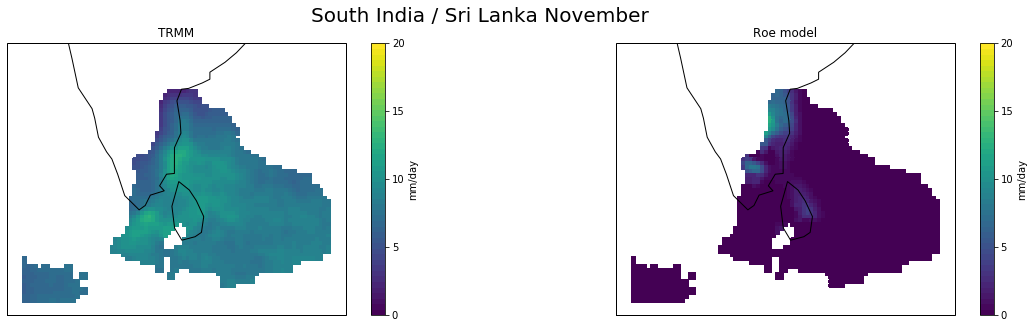

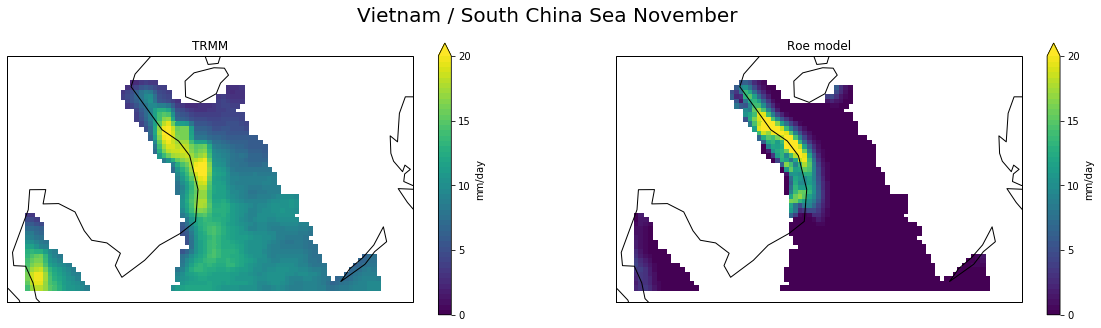

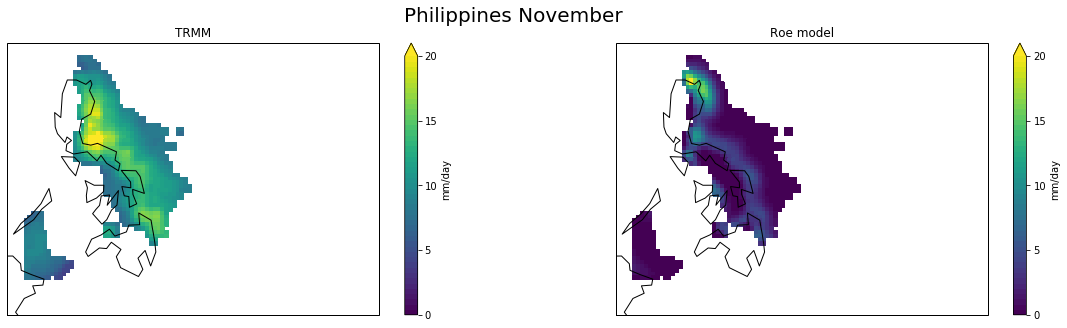

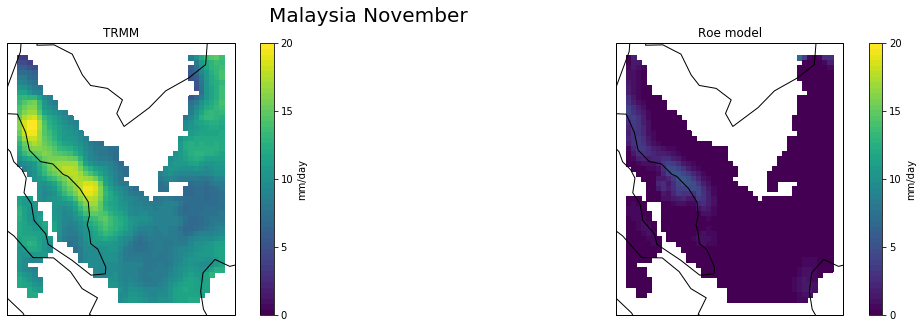

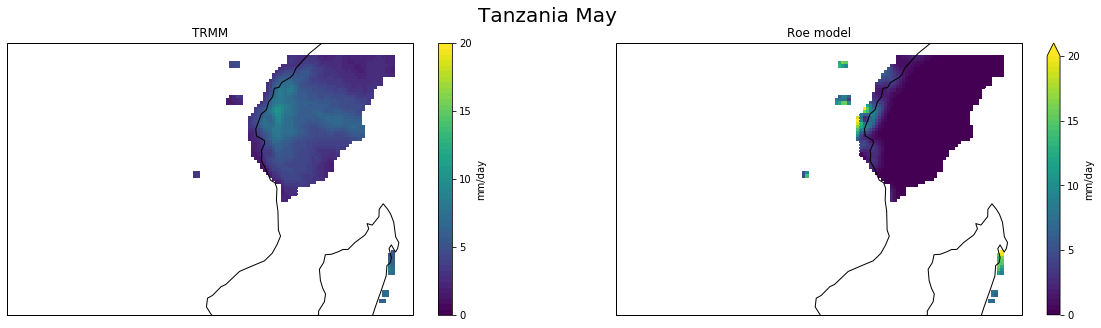

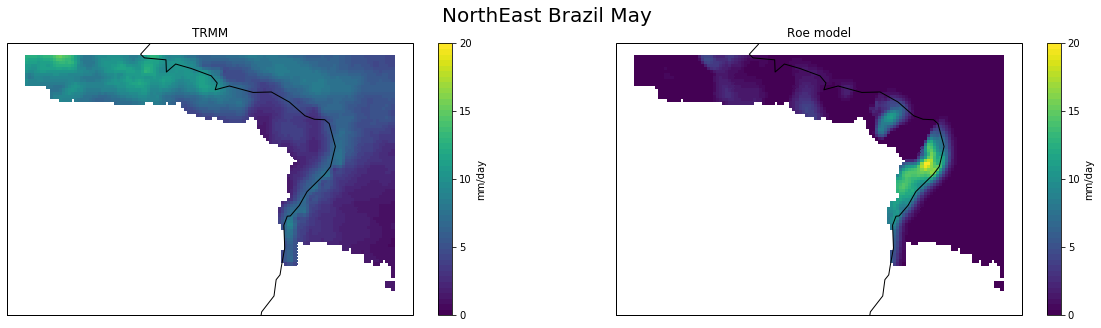

In [69]:
def plot_precips(boxes,maskk,pr1,pr2,month,names):
    for i,box in enumerate(boxes):
        mask = maskk.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        
        pr1_box = pr1.interp_like(mask).sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2])) 
        pr2_box = pr2.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))   
        
        pr1_box = pr1_box.where(mask==1)
        pr2_box = pr2_box.where(mask==1)
        
        M = 20.
        fig, ax = plt.subplots(1,2,figsize=(20,5),subplot_kw={'projection': ccrs.PlateCarree()})
        pr1_box.plot(ax=ax[0],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
        pr2_box.plot(ax=ax[1],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":np.arange(0,M+1,M/4)},levels=np.linspace(0,M,50))
        ax[0].set_title("TRMM")
        ax[1].set_title("Roe model")
        ax[0].coastlines()
        ax[1].coastlines()
        
        fig.suptitle(names[i]+" %s"%month,fontsize=20)
        
        #trmmmask = cartopy.feature.ShapelyFeature(mask,ccrs.PlateCarree())
        #ax[0].add_feature(trmmmask, zorder=100, edgecolor='k')
        
plot_precips(boxNH1,trmm_nh_winter_mask1,pr_trmm_nov,pr_roe_nov,"November",namesNH)
plot_precips(boxSH1,trmm_sh_winter_mask1,pr_trmm_may,pr_roe_may,"May",namesSH)
